In [1]:
from graviz import graph_processing
import json
import pickle
from BuildGraphModule import *
import networkx as nx
import community as com
from UniformData import *
import numpy as np
from MultiGraph import *
import matplotlib.pyplot as plt
%matplotlib inline

# Adding some useful statistics to the nodes in the graph
### If you run from scratch and there are no precomputed files run following cells skip loading graph agian in next section, otherwise start in the next section

In [ ]:
graph = graph_processing.load_graph('graph.json', 'JSON')

In [ ]:
# it takes approximately 10 minutes using 8 cores
graph, degree_nodes, eigenvector_nodes, betweenness_nodes = graph_processing.add_centrality_stats(graph)

In [ ]:
graph_processing.save_graph(graph, 'graviz/graph_centrality_serialized.json', 'JSON')

# Trimming graph according to eigenvector centrality measure

In [2]:
graph = graph_processing.load_graph('graviz/graph_centrality_serialized.json', 'JSON')
eigenvector_nodes = nx.get_node_attributes(graph, 'eigenvector_centrality')
betweenness_nodes = nx.get_node_attributes(graph, 'betweenness_centrality')

In [3]:
graph = graph_processing.reduce_graph_size(graph, eigenvector_nodes, threshold=2500)

In [4]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 2500
Number of edges: 17492
Average degree:  13.9936


In [5]:
with open('paper.json', 'r') as f:
    data = json.load(f)

In [6]:
# Uniform strings - Authors
data = uniform_authors(data)

In [7]:
# Uniform strings - EPFL Authors
data = uniform_epfl_authors(data)

In [8]:
# Hence, we cut the data we work on
data_cut = cut_data(data)

In [ ]:
# We built three different dictionary that may be used later. The function documentation provides informations about
dict_lab_site, dict_labs, dict_labs_paper = lab_dictionaries(data_cut)

In [11]:
list_schools = ['ENAC', 'SB', 'IC', 'STI', 'SV']
dict_lab_school = {}
for school in list_schools:
    dict_lab_school = {**dict_lab_school, **school_lab(dict_lab_site, school)}

In [12]:
author_lab = pickle.load(open('author_lab.p', 'rb'))

In [13]:
dict_schools = {'ENAC':1, 'SB':2, 'IC':3, 'STI':4, 'SV':5}

In [14]:
authors = nx.get_node_attributes(graph, 'author_id')

In [15]:
proper_values = []
for node in graph.nodes():
    try:
        proper_values += [dict_schools[dict_lab_school[author_lab[authors[node]]]]]
    except:
        proper_values += [0]

In [16]:
parts = com.best_partition(graph)

In [17]:
values = [parts.get(node) for node in graph.nodes()]

In [18]:
nodes_positions = nx.spring_layout(graph)

In [19]:
nodes_positions_mod = nodes_positions
max_label = max(values)

In [20]:
# parameters for community shift
#r = 1
a = 0.6
b = 0.85
for key in nodes_positions_mod:
    # circle or elipse placement
    #nodes_positions_mod[key] += [r/2 * np.cos(2.0 * np.pi * parts[key] / max_label), r * np.sin(2.0 * np.pi * parts[key] / max_label)]
    # logarithmic spiral placement
    nodes_positions_mod[key] += [a * np.exp(b * (1 - parts[key] / max_label)) * np.cos(2.0 * np.pi * (1 - parts[key] / max_label)), a * np.exp(b * (1 - parts[key] / max_label)) * np.sin(2.0 * np.pi * (1 - parts[key] / max_label))]

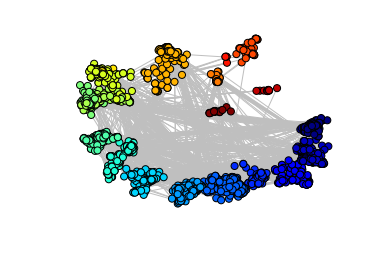

In [21]:
plt.figure(figsize=(15,8), dpi=80)
plt.axis("off")
nx.draw_networkx(graph, pos=nodes_positions_mod, cmap=plt.get_cmap("jet"), node_color=values, edge_color=['0.75'] * len(graph.edges()), node_size=50, with_labels=False)
plt.savefig("Images/communities_found.png", format="PNG", dpi=300)

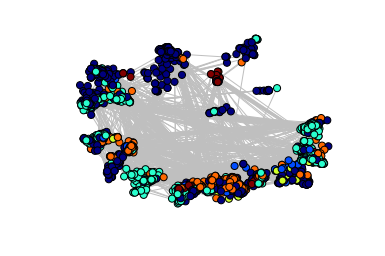

In [22]:
plt.figure(figsize=(15,8), dpi=80)
plt.axis("off")
nx.draw_networkx(graph, pos=nodes_positions_mod, cmap=plt.get_cmap("jet"), node_color=proper_values, edge_color=['0.75'] * len(graph.edges()), node_size=50, with_labels=False)
plt.savefig("Images/communities_proper.png", format="PNG", dpi=300)